## Modelado de opiniones y su impacto en la generación de consensos y disensos en una plataforma de CrowdSourcing

El objetivo de la simulación es dilucidar el funcionamiento de las dinámicas de opinión en una plataforma de CrowdSourcing donde las personas expresan sus opiniones y votan las expresadas por otros bajo una serie de condiciones especificadas por el contexto de la plataforma.

In [1]:
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt, math, scipy, seaborn as sns, warnings, matplotlib
from scipy.stats import multivariate_normal
from scipy.spatial import distance
from pandas import Series, DataFrame
from uuid import uuid4
# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

TamañoDeLaMuestra = [100, 200, 500, 1000] # Cantidad de agentes que quiero en la muestra.

# Agentes

## Agente

Agente es una clase que cuenta con los siguientes atributos:

* **Oi** = Contiene la opinion de cada agente. Va a ser siempre numerico pero dependiendo la simulacion puede ser un solo numero (real) o un vector de varios numeros (reales), independientemente de como se generan que siempre lo hacen a partir de la realizacion de algun tipo de distribucion conocida en un espacio univariado o multivariado.  
* **ID** = Es un numero entero de identificacion unico para cada sujeto.
* **IdeasVistas** = Es una lista que contiene los IDs de las ideas que va a ver este agente.  
* **IdeasVotadas** = Es una lista que contiene los IDs de las ideas que va a ver este agente.
* **Valencias** = Es una lista que contiene el valor que toma el voto de este agente.
* **Tipo** = Es el tipo de distribucion que se utilizo para asignarle la opinion.
* **Media** = Es la media de la distribucion.
* **DE** = Es el desvio estandar de la distribucion.

In [2]:
class Agente (object):
    def __init__ (self, tipo, media, ID, de = 0.5, dimensiones = 3):
        self.Oi = self.set_Oi (tipo, media, de, dimensiones)
        self.ID = ID
        self.IdeasVistas = []
        self.IdeasVotadas = []
        self.Valencias = []
        self.Tipo = tipo
        self.Media = media
        self.DE = de

    def set_Oi (self, tipo, media, de, dimensiones):
        # Asume que se le da el tipo de distribucion ['uniforme', 'univariada', 'multivariada'], 
        # la media (que debe ser una lista con un numero entero), el desvio estandar (normalmente fijo en 0.50), 
        # y la cantidad de dimensiones para el caso de la multivariada (normalmente fijado en 3).
        # En base a eso devuelve una lista con la/s opinion/es del agente.
        
        if tipo not in ['uniforme', 'univariada', 'multivariada']:
            raise Exception("El tipo de opinion solo puede ser ""uniforme"", ""univariada"" o ""multivariada")
        
        elif isinstance(media, list) == False:
            raise Exception("El argumento media solo acepta listas")
        
        opinion = []
        mediasu = []
        
        if tipo == "uniforme":
            if len(media) != 2:
                raise Exception("La media del tipo uniforme debe contener un start y un end")
            opinion.append (random.uniform (media[0],media[1]))
            mediasu += media 
            
        if tipo == "univariada":
            if len(media) != 1:
                raise Exception("La media de la univariada no puede contener mas de un numero")
            opinion = np.random.normal (media,de)
            mediasu = media
                    
        if tipo == "multivariada":
            if len(media) == 1:
                for i in range (dimensiones):
                     mediasu += media
                a = multivariate_normal.rvs(mediasu, de)
                opinion = a.tolist()
                    
            else:
                a = multivariate_normal.rvs(media, de)
                opinion = a.tolist()
                mediasu = media
   
        return opinion

    def append_IdeasVistas (self, IdeaVista):
        self.IdeasVistas.append (IdeaVista)

    def append_IdeasVotadas (self, IdeaVotada):
        self.IdeasVotadas.append (IdeaVotada)   

    def append_Valencias (self, Valencias):
        self.Valencias.append (Valencias) 

    def ListaVotos (self, VotosPos, VotosNeg):
        # Asume que se le da dos numeros enteros, correspondientes a los votos positivos y negativos
        # que se le piden al agente y en base a eso devuelve una lista en la cual los 1 representan 
        # los votos positivos y los -1 los negativos.
        
        votos = VotosPos * [1] + VotosNeg * [-1]
        return votos

    def comparar (self, idea): 
        # Asume que se le da una lista con la/s opinion/es de otro agente (Oj) y la compara con la del agente (Oi).
        # Devuelve la distancia entre ellas.
        
        if len(idea) > 1:
            Distancia = distance.euclidean(self.Oi,idea)
        else:
            Distancia = abs(self.Oi[0]-idea[0])
        return Distancia
    
    def get_Oi (self):
        return self.Oi
    
    def get_IdeasVistas (self):
        return self.IdeasVistas

    def get_ID (self):
        return self.ID

    def get_Tipo (self):
        return self.Tipo
    
    def get_Media (self):
        return self.Media
    
    def get_DE (self):
        return self.DE

    def clean_IdeasVistas (self):
        self.IdeasVistas = []

### Agente Nulo

In [3]:
class AgenteNulo (Agente):
    # El agente nulo se caracteriza por la votacion aleatoria.
    
    def votar (self, ideas): 
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente) 
        # y vota aleatoriamente. Devuelve un dataframe con el tipo de voto asignado a cada index (que 
        # representa el orden en el que los agentes ingresaron a la plataforma)
        
        self.IdeasVistas.append (ideas)
        Votara = ideas.sample (n = QIdeasAVotar)
        votos = self.ListaVotos(VotosPos, VotosNeg)
        vota = []
        for i in Votara.index:
            vota.append (i)
        self.IdeasVotadas.append (vota)
        self.Valencias.append (votos)
        devuelve = pd.DataFrame(votos, vota)
        return devuelve

## Agente Determinista

In [4]:
class AgenteDeterminista (Agente):
    # El agente Determinista se caracteriza por la votacion determinada por la distancia.
    # Es decir votara la/s idea/s mas cercanas positivamente, y la/s mas lejanas negativamente.

    def algvotar (self, ideas, tipo): 
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente) 
        # y devuelve segun se le pida, el indice de la idea mas cercana o lejana.
        
        Comp = 1000
        CompNeg = -1000
        vota = 0
        for i in ideas.index:
            V = self.comparar (ideas.at[i,'Opinion'])
            if V == Comp or V == CompNeg:
                vota = random.choice (i, vota)
            elif tipo == "Positivo":
                if V < Comp:
                    vota = i
                    Comp = V
            elif tipo == "Negativo":
                if V > CompNeg:
                    vota = i
                    Comp = V                
        return vota # Me devuelve la id de la idea a votar
        
    def votar (self, ideas):
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente) 
        # y vota utilizando el algoritmo de algvotar. Devuelve un dataframe con el tipo de voto asignado a cada 
        # index (que representa el orden en el que los agentes ingresaron a la plataforma).
        
        self.IdeasVistas.append (ideas)
        ideas2 = ideas.copy ()
        vota = []
        votos = self.ListaVotos(VotosPos, VotosNeg)
        for i in votos:
            if i == 1:
                va = int (self.algvotar (ideas2, "Positivo"))
                ideas2.drop (va, inplace=True)
                vota.append (va)
            if i == -1:
                va = int(self.algvotar (ideas2, "Negativo"))
                ideas2.drop (va, inplace=True)
                vota.append (va)
        self.IdeasVotadas.append (vota)
        self.Valencias.append (votos)
        devuelve = pd.DataFrame(votos, vota)
        return devuelve

## Agente Probabilistico

In [5]:
class AgenteProbabilistico (AgenteDeterminista):
    # El agente Probabilistico se caracteriza por la votacion dada por la probabilidad de elegir la idea
    # inversamente proporcional a la distancia para el caso positivo, o proporcional a la distancia
    # para el caso negativo.
    
    def algvotar (self, ideas, tipo):
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente)
        # calcula las distancias y vota acorde a la probabilidad. Devuelve la ID de la idea que haya sido seleccionada.
        
        Wm = ideas.copy()
        for i in Wm.index:
            Wm.at [i,'Distancia'] = self.comparar (Wm.at[i,'Opinion'])
        if tipo == "Positivo":
            for i in Wm.index:
                Wm.at [i,'Distancia'] = abs(1 - Wm.at [i,'Distancia'])
            SumaDistancias = Wm["Distancia"].sum()
            for i in Wm.index:
                Wm.at [i,'Probabilidad'] = abs(Wm.at [i,'Distancia']) / SumaDistancias
            vota = np.random.choice(Wm.index.values.tolist(), 1, p=  Wm["Probabilidad"].values.tolist())
            
        if tipo == "Negativo":
            SumaDistancias = Wm["Distancia"].sum()
            for i in Wm.index:
                Wm.at [i,'Probabilidad'] = Wm.at [i,'Distancia'] / SumaDistancias
            vota = np.random.choice(Wm.index.values.tolist(), 1, p=  Wm["Probabilidad"].values.tolist())
            
        return vota # Me devuelve la id de la idea a votar

    def votar (self, ideas):
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente) 
        # y vota probabilisticamente, con una probabilidad inversamente proporcional a la distancia para 
        # el caso positivo, o proporcional a la distancia para el caso negativo (lo cual estara 
        # determinado por la funcion algvotar). Devuelve un dataframe con el tipo de voto asignado a cada 
        # index (que representa el orden en el que los agentes ingresaron a la plataforma).
        
        self.IdeasVistas.append (ideas)
        ideas2 = ideas.copy ()
        vota = []
        votos = self.ListaVotos(VotosPos, VotosNeg)
        for i in votos:
            if i == 1:
                va = int (self.algvotar (ideas2, "Positivo"))
                ideas2.drop (va, inplace=True)
                vota.append (va)
            if i == -1:
                va = int(self.algvotar (ideas2, "Negativo"))
                ideas2.drop (va, inplace=True)
                vota.append (va)
        self.IdeasVotadas.append (vota)
        self.Valencias.append (votos)
        devuelve = pd.DataFrame(votos, vota)
        return devuelve

### Metodos se seleccion de ideas

Esta funcion define la manera en que se va a controlar las ideas que le van a ser presentadas a un agente. Existen dos metodos con que se pueden seleccionar las ideas dependiendo del argumento `tipo` pasado a la funcion.

* Metodo uno (`tipo = 'menos vistas'`): Comprende elegir aquellas ideas que tengan menor cantidad de vistas
* Metodo dos (`tipo = 'ratio'`): Comprende elegir en partes iguales, la mitad de las ideas segun la cantidad de vistas igual que con el metodo uno y la otra mitad de las ideas segun el ratio de votos positivos y cantidad de vistas.   

In [6]:
def metodo_de_seleccion (lista, tipo):
    
    if tipo == "menosvistas":
        lista.sort_values(by='Vistas', inplace=True)
        Devuelve = lista.iloc[:QOpinionesExpuestas, :2]
        return Devuelve

    if tipo == "ratio":
        lista.sort_values(by=['Vistas'], ascending = True, inplace = True)
        OpinionesMenosVistas = lista.iloc[:10, :2] 
        OpinionesMenosVistasSeleccionadas = OpinionesMenosVistas.sample (n= math.floor (QOpinionesExpuestas / 2))
        lista.sort_values(by='Ratio', ascending=False, inplace=True)
        OpinionesConMayorRatio = lista.iloc[:10, :2]
        OpinionesConMayorRatioSeleccionadas = OpinionesConMayorRatio.sample (n= math.ceil (QOpinionesExpuestas / 2))
        OpinionesParaVotar = pd.concat([OpinionesMenosVistasSeleccionadas, OpinionesConMayorRatioSeleccionadas])
        print (OpinionesParaVotar)
        return OpinionesParaVotar

### Simulacion Nula

Se crea un diccionario para albergar a todos los agentes que van a componer la muestra. Para crear el diccionario se itera sobre el rango del tamaño de la muestra a usar (estando los distintos tamaños definidos en una lista) y se genera un nuevo elemento del diccionario (una instancia de la clase correspondiente a algun tipo de agente) con un indice igual al ID del sujeto. 

#### Variables de la muestra

Para la muestra de la simulacion es necesario definir algunas variables que van a determinar el tipo de distribucion que tendra la opinion de los agentes. Estas variables son:

* `Tipo` = Representa la distirbucion que va a tomar la opinion del sujeto,  puede ser  'uniforme', ' univariada' o 'multivariada'.
* `Media` = Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas 

In [7]:
Tipo = 'univariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

#### Creo la muestra

In [8]:
Muestra_Completa = {}
for k in range (1,TamañoDeLaMuestra[1]):
    Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))

#### Variables de entorno

Para el contexto de la simulacion es necesario definir algunas variables que van a determinar el contexto de la plataforma en la cual los agentes van a interactuar. Estas variables son:

* `QOpinionesExpuestas` = La cantidad de opiniones que va a ver cada agente. 
* `QVecesMuestroOpinion` = La cantidad minima de veces que quiero que se muestre alguna opinion, toda opinion de esta manera tiene que mostrarse al menos esta cantidad de veces. 
* `VotosPos` = Cuantos votos positivos tiene disponible cada agente.
* `VotosNeg` = Cuantos votos negativos tiene disponible cada agente.
* `QIdeasAVotar` = La cantidad total de ideas que un agente va a votar lo cual esta dado por la suma de la cantidad de votos negativos y positivos disponible para cada agente. 

In [9]:
MetodoDeSeleccionDeIdeas = 'menosvistas' # Puede ser ['menosvistas' o 'ratio']
QOpinionesExpuestas = 5 
QVecesMuestroOpinion = 15
VotosPos = 2
VotosNeg = 1
QIdeasAVotar = VotosPos + VotosNeg

#### Simulacion

Para la simulacion es necesario definir algunas variables. Estas variables son:

* `Muestra_Simulacion` = Es una copia de la muestra completa que se utilizara para esta simulacion en especifico. 
* `DataSave` = Es un array que almacenara la ID del sujeto, su opinion, la cantidad de votos (positivos y negativos), la cantidad de vistas, y el ratio (Vistas/Votos).
* `MinutoAMinuto` = Es un array que almacena lo que va sucediendo paso por paso en la simulacion.
* `OpinanNoVotan` y `TiempoSimulacion` son dos variables que sirven a modo funcional de la simulacion.

In [10]:
Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
DataSave = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinuto = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
#     if OpinanNoVotan < QOpinionesExpuestas: # Lo cambio porque sino el metodo ratio no funciona
    if OpinanNoVotan < 11:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        DataSave.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = DataSave[DataSave.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas, MetodoDeSeleccionDeIdeas) # Creo un dataframe con las ideas que va a ver el sujeto
        DataSave.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.loc[i].at[0] == 1:
                DataSave.at [i,'VotosPos'] = DataSave.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.loc[i].at[0] == -1:
                DataSave.at [i,'VotosNeg'] = DataSave.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            DataSave.at [i,'Vistas'] = DataSave.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            DataSave.at [i, 'Ratio'] = DataSave.at[i, 'VotosPos'] / DataSave.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinuto.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinuto.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

            
            
print (DataSave)
print (MinutoAMinuto)

C:\Users\Mariano\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:993: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)


                                       ID                 Opinion VotosPos  \
0    046095bd-826e-4f19-89fe-8e7edae3b9f7   [-0.5036578993999115]        1   
1    799f27f4-9ae6-40f6-8b24-99b589b6b893   [-0.4173033688749328]        2   
2    d9064ae9-2451-48d3-a496-58ba9fd98740    [0.3135677319266026]        2   
3    8cb89cf3-ee19-4459-af50-fa797fc0cb01   [-0.6831872209422598]        0   
4    26c88519-2a4b-4cdd-b66f-387065fc29e3  [-0.39506052251783164]        2   
..                                    ...                     ...      ...   
195  989912a0-45b6-4d09-ad7f-419a69ab2680   [-0.6014628885579107]        0   
196  b200caa3-6133-4e78-87da-5c399c052a87  [0.011315682041739281]        1   
197  f93b3123-4cc4-4605-b807-a7301e9a5e22  [-0.02304169678035828]        1   
198  3184d29f-4ae9-493b-bd40-465997ae447f    [0.6844750756754132]        1   
199  9cebffa8-a43b-4072-a683-5fda70baa92a    [0.4468056684556609]        0   

    VotosNeg Vistas     Ratio  
0          2      4      0.25  

#### Graficos

A1. Distribuciòn de cantidad de visualizaciones


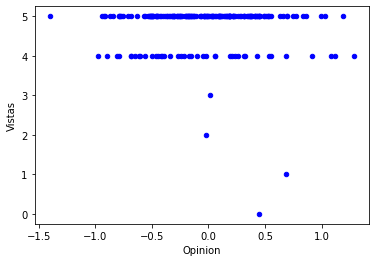

B1. Distribución de votos positivos


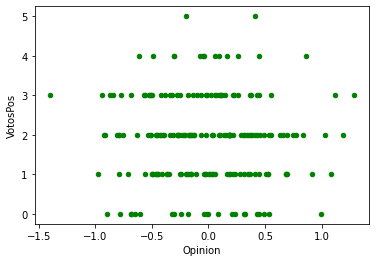

B2. Distribución de votos positivos para ideas que tengan mas de 0 votos positivos


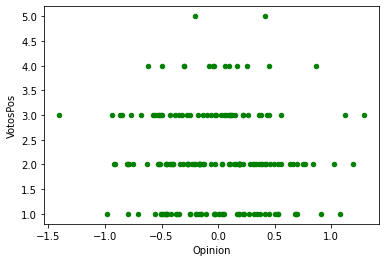

C1. Distribución de votos negativos


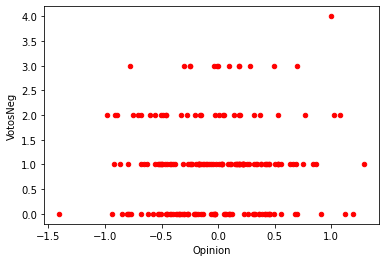

C2. Distribución de votos negativos para ideas que tengan mas de 0 votos negativos


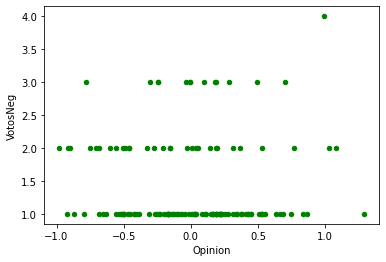

D1. Distribución de rates


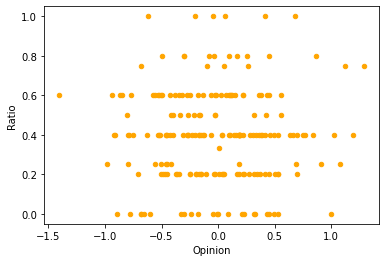

D21. Distribución de rates para ideas que tengan al menos 1 votos pos y 1 votos neg


<ipython-input-11-0210e126e229>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  VotosFiltrados = VotosPosFiltrados[DataSave.VotosNeg > LimVotNeg]


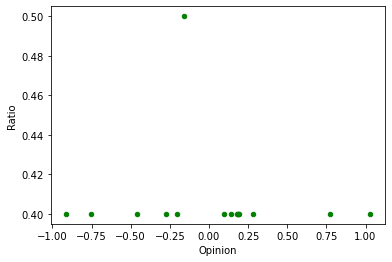

E1. Distribución de rates x visualizaciones


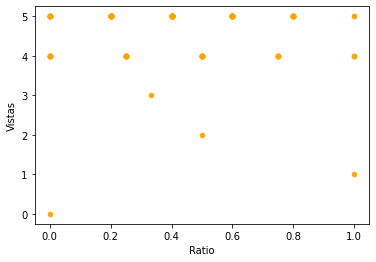

E2. Distribución de rates x visualizaciones


In [11]:
if Tipo in ['uniforme','univariada']:
    
    for i in DataSave.index:
    # Para hacer que la opinion no sea una lista.
        DataSave.at [i,'Opinion'] = DataSave.at [i,'Opinion'][0]
    
    # A1. Distribuciòn de cantidad de visualizaciones
    print ('A1. Distribuciòn de cantidad de visualizaciones')
    A1 = DataSave.plot(kind='scatter',x='Opinion',y='Vistas',color='blue')
    plt.show()
    
    # B1. Distribución de votos positivos.
    print ('B1. Distribución de votos positivos')
    B1 = DataSave.plot(kind='scatter',x='Opinion',y='VotosPos',color='green')
    plt.show()
    
    # B2. Distribución de votos positivos para ideas que tengan mas de 0 votos positivos
    print ('B2. Distribución de votos positivos para ideas que tengan mas de 0 votos positivos')
    VotosPosFiltrados = DataSave[DataSave.VotosPos > 0]
    B2 = VotosPosFiltrados.plot(kind='scatter',x='Opinion',y='VotosPos',color='green')
    plt.show()
    
    # C1. Distribución de votos negativos.
    print ('C1. Distribución de votos negativos')
    C1 = DataSave.plot(kind='scatter',x='Opinion',y='VotosNeg',color='red')
    plt.show()
    
    # C2. Distribución de votos negativos para ideas que tengan mas de 0 votos negativos
    print ('C2. Distribución de votos negativos para ideas que tengan mas de 0 votos negativos')
    VotosNegFiltrados = DataSave[DataSave.VotosNeg > 0]
    C2 = VotosNegFiltrados.plot(kind='scatter',x='Opinion',y='VotosNeg',color='green')
    plt.show()
    
    # D1. Distribución de rates.
    print ('D1. Distribución de rates')
    D1 = DataSave.plot(kind='scatter',x='Opinion',y='Ratio',color='orange')
    plt.show()
    
    # D2. Distribución de rates para ideas que tengan al menos X votos pos o neg
    LimVotPos = 1
    LimVotNeg = 1
    print ('D21. Distribución de rates para ideas que tengan al menos ' + str(LimVotNeg) + ' votos pos y '  + str(LimVotNeg) + ' votos neg')
    VotosPosFiltrados = DataSave[DataSave.VotosPos > LimVotPos]
    VotosFiltrados = VotosPosFiltrados[DataSave.VotosNeg > LimVotNeg]
    D2 = VotosFiltrados.plot(kind='scatter',x='Opinion',y='Ratio',color='green')
    plt.show()
        
    
    # E1. Distribución de rates x visualizaciones
    print ('E1. Distribución de rates x visualizaciones')
    E1 = DataSave.plot(kind='scatter',x='Ratio',y='Vistas',color='orange')
    plt.show()
    
    # E2. Distribución de rates x visualizaciones
    print ('E2. Distribución de rates x visualizaciones')